# Bem vindo ao Jupyter Notebook do Laboratório ARIMA

Comece conhecendo a interface disponível em "Help/User Interface Tour"

Caso queira se aprofundar um pouco mais, [clique aqui](https://mybinder.org/v2/gh/jvns/pandas-cookbook/master), espera a página carregar e dirija-se ao 'CookBook'

Iremos

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates

## Agrupando os dois dias num único dataframe
Um "Dataframe" é um formato de apresentação de dados muito parecido com o do Excel mas pensado para as necessidade e limitações da Ciência de Dados

Como foi visto no diretorio, 
Nessa etapa, iremos juntar os


In [3]:
# Importa os dataframes agrupados e converte coluna para datetime

df2=pd.read_csv("20180906_grouped-Copy1.csv",
                sep=';',
                decimal='.')
df2['Data']=pd.to_datetime(df2['Data'])

df3=pd.read_csv("20180921_grouped-Copy1.csv",
                sep=';',
                decimal='.')
df3['Data']=pd.to_datetime(df3['Data'])

In [4]:
# Transforma as datas em dias consecutivos
df2['Data']=df2['Data'].apply(lambda x: x.replace(month=1, day=2, hour=x.hour, minute=x.minute, second=x.second))
df3['Data']=df3['Data'].apply(lambda x: x.replace(month=1, day=3, hour=x.hour, minute=x.minute, second=x.second))

In [5]:
# Consolida os dois dias em um unico dataframe

df = pd.concat([df2,df3],axis=0).reset_index(drop=True)
display(df)

,Data,Local,VelMed,Qtde
0,2018-01-02 00:00:00,2400.0,116.181818,11
1,2018-01-02 00:00:00,2401.0,58.666667,9
2,2018-01-02 00:00:00,2402.0,97.250000,5
3,2018-01-02 00:00:00,2403.0,101.000000,6
4,2018-01-02 00:00:00,2404.0,107.857143,7
...,...,...,...,...
1101638,2018-01-03 23:57:00,7166.0,144.333333,6
1101639,2018-01-03 23:57:00,7168.0,115.428571,7
1101640,2018-01-03 23:57:00,7172.0,67.000000,13
1101641,2018-01-03 23:57:00,7176.0,183.000000,1


## Plotando o seu primeiro gráfico

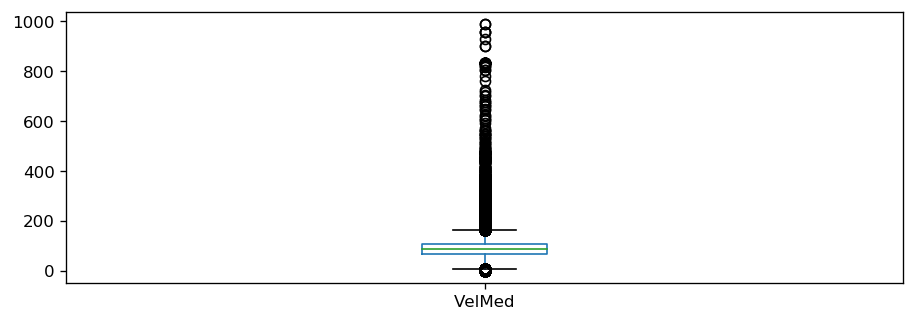

In [15]:
df.VelMed.plot(kind='box')
plt.show()

## Selecao do radar e horario a ser previsto

In [7]:
# Seleciona um unico radar
# Seleciona horario para realizar a previsao
radar = 4326
hora = '13:00:00'

df_u = df[df['Local']==4326].reset_index(drop=True)

division = df_u.loc[df_u['Data']=='2018-01-03 ' + hora].index[0]
start = division - 100

# Separa em treino e validação
train = df_u.loc[start:division]
test  = df_u.loc[division:]

## Determinacao dos parâmetros do ARIMA

### Checar se a série é estacionária

In [19]:
result = adfuller(df_u.Qtde)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.223283
p-value: 0.018676


Para o radar escolhido, ve-se que a série pode ser considerada estacionária (p-value inferior a 0.05). Por isso, não será realizado nenhuma diferenciação (d=0). No entanto, faremos a validação visual para certificar-nos do resultado apontado pelo teste ADF

### Validação Visual

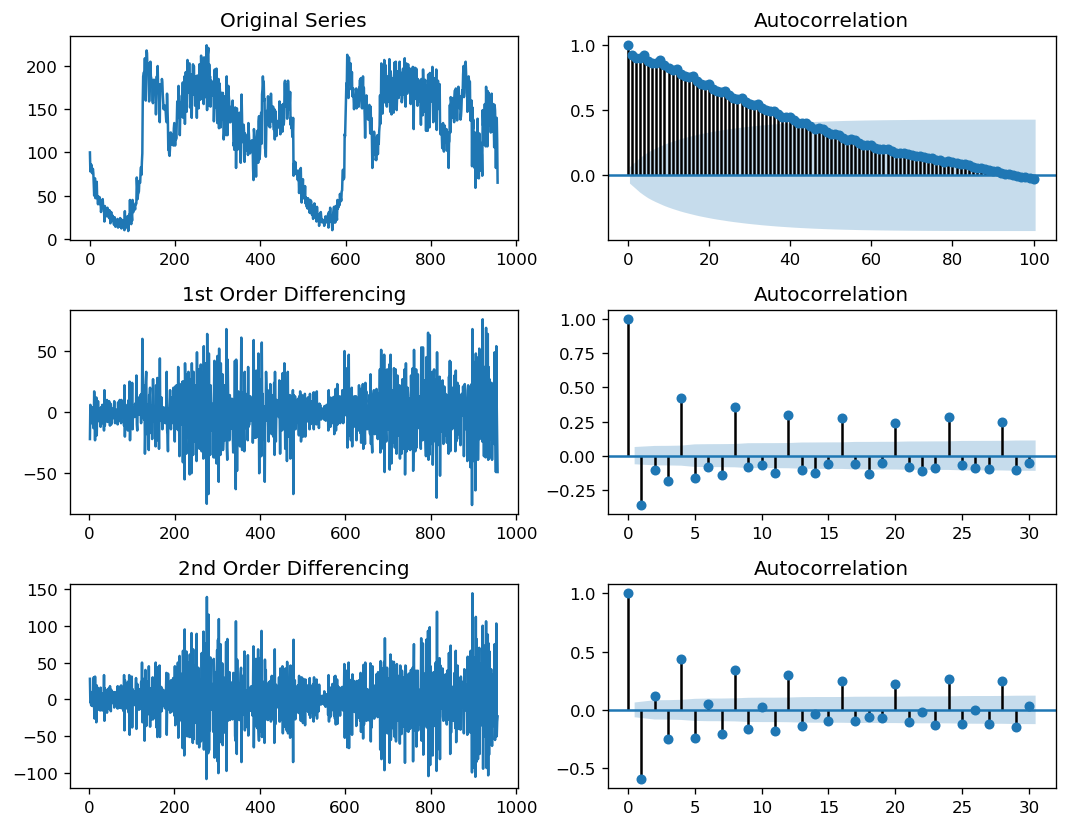

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_u.Qtde); axes[0, 0].set_title('Original Series')
plot_acf(df_u.Qtde, ax=axes[0, 1], alpha=0.05, lags=100)

# 1st Differencing
axes[1, 0].plot(df_u.Qtde.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_u.Qtde.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_u.Qtde.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_u.Qtde.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

Os plots mostram que na primeira diferenciação, a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=0 é realmente o ideal

### Ordem da Auto-Regressão

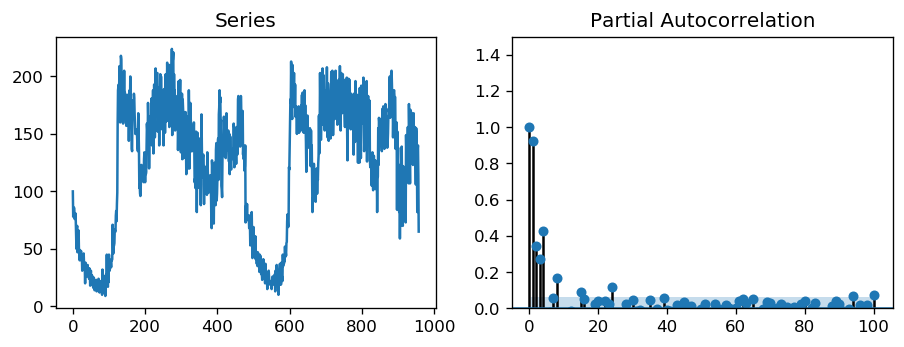

In [10]:
# PACF
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_u.Qtde); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.5))
plot_pacf(df_u.Qtde, ax=axes[1], lags= 100)

plt.show()

Pelo gráfico, vemos que os quatro primeiros lags possuem correlação acima do nível de confiança exigido (delimitado pela área azul). Por isso, utilizaremos p=4.

### Ordem da Média-Movel

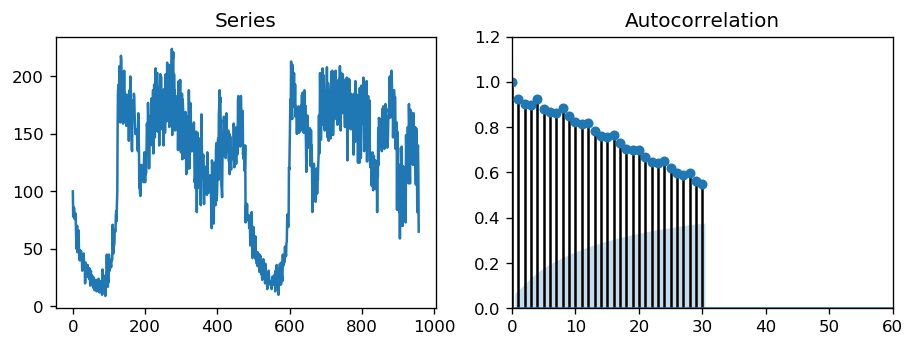

In [11]:
ig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_u.Qtde); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.2), xlim=(0,60))
plot_acf(df_u.Qtde, ax=axes[1])

plt.show()

A autocorrelação decai muito lentamente para a série em questão. Isso nos daria um treshold máximo da ordem de 40. No entanto, a componente de média móvel dos modelos ARIMA raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 1 para manter o modelo simples.

## Construção do modelo e previsão

In [12]:
# De_para para mostrar a localizacao do radar
de_para = pd.read_csv('de_para-Copy1.csv')

In [13]:
# Steps a serem previstos
p = 4 #Autoregressao
d = 0 #Diferenciacao
q = 1 #MediaMovel
steps = 15 #Steps Previstos

test=test[:steps]

# Istancia o modelo e fita no treino
model = ARIMA(train['Qtde'],order=(p,d,q))
model_fit=model.fit(disp=-1)

# Realiza forecast
fc, se, conf = model_fit.forecast(steps, alpha=0.05)  # 95% conf

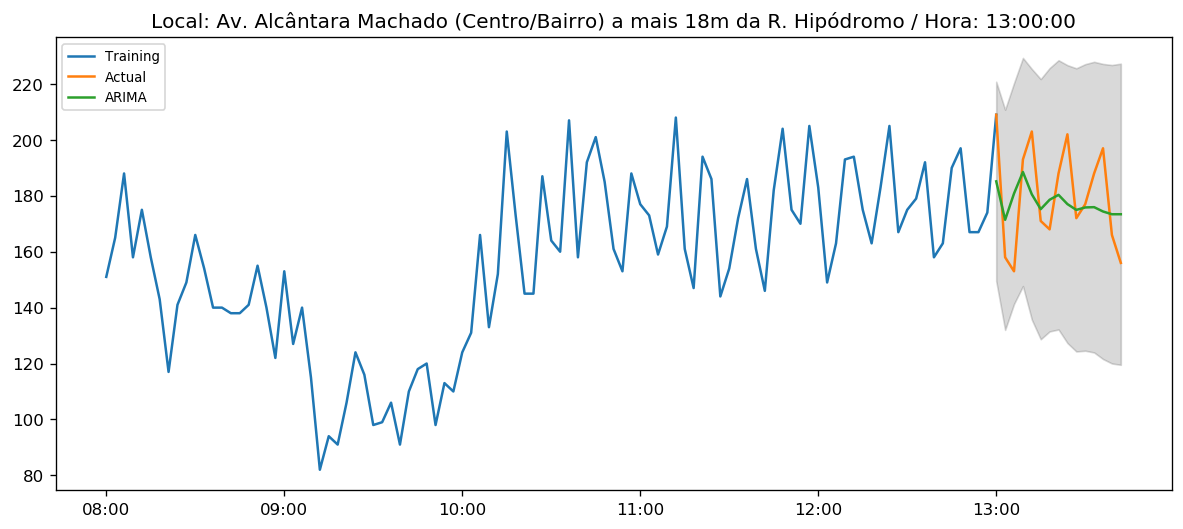

In [14]:
fc_series = pd.Series(fc, index=test.index)

lower_series = pd.Series(conf[:, 0], index=test.Data)
upper_series = pd.Series(conf[:, 1], index=test.Data)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train['Data'], train['Qtde'], label='Training')
ax.plot(test['Data'], test['Qtde'], label='Actual')
ax.plot(test['Data'], fc_series, label='ARIMA')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
plt.title('Local: '+str(de_para.loc[de_para['Local']==radar,'Descricao'].reset_index(drop=True)[0])+' / Hora: '+hora)
plt.legend(loc='upper left', fontsize=8)
plt.show()